# Proyek Analisis Data: Brazilian E-Commerce Public Dataset
- **Nama:** Bagus Cahyo Arrasyid
- **Email:** m004d4ky1524@bangkit.academy
- **ID Dicoding:** baguscahyoo

## Menentukan Pertanyaan Bisnis

- Produk apa yang paling laris? 
- Keuntungan terbesar datang dari barang mahal atau barang murah?

## Import Semua Packages/Library yang Digunakan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import matplotlib.image as mpimg
from scipy import stats

## Data Wrangling

### Gathering Data

In [2]:
customers = pd.read_csv("./E-Commerce Public Dataset/customers_dataset.csv")
geolocation = pd.read_csv("./E-Commerce Public Dataset/geolocation_dataset.csv")
order_items = pd.read_csv("./E-Commerce Public Dataset/order_items_dataset.csv")
order_payments = pd.read_csv("./E-Commerce Public Dataset/order_payments_dataset.csv")
order_reviews = pd.read_csv("./E-Commerce Public Dataset/order_reviews_dataset.csv")
orders = pd.read_csv("./E-Commerce Public Dataset/orders_dataset.csv")
product_category = pd.read_csv("./E-Commerce Public Dataset/product_category_name_translation.csv")
products = pd.read_csv("./E-Commerce Public Dataset/products_dataset.csv")
sellers = pd.read_csv("./E-Commerce Public Dataset/sellers_dataset.csv")

data = {'customers': customers, 'location': geolocation, 'items': order_items, 'payments': order_payments, 'reviews': order_reviews,
        'orders': orders, 'category': product_category, 'products': products, 'sellers': sellers,}

### Assessing Data

- Melihat info data

In [3]:
for df_name, df in data.items():
  print('\n', data[df_name].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB

 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non

- Missing value

In [4]:
def calculate_null_counts(data):
    # Inisialisasi dictionary untuk menyimpan jumlah nilai null untuk setiap DataFrame
    null_counts = {}

    # Menghitung dan menyimpan jumlah nilai null untuk setiap DataFrame
    for df_name, df in data.items():
        null_counts[df_name] = df.isna().sum()
        print(df_name, '\n', null_counts[df_name], '\n')

    return null_counts

# Memanggil fungsi untuk menghitung nilai null
null_counts = calculate_null_counts(data)

customers 
 customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64 

location 
 geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64 

items 
 order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64 

payments 
 order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64 

reviews 
 review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64 

orders 
 order_id     

- Mengubah format timestamp 

In [5]:
# Fungsi untuk mengkonversi kolom menjadi tipe data datetime
def convert_to_datetime(df, columns):
    for column in columns:
        df[column] = pd.to_datetime(df[column])
    return df

# Kolom-kolom yang berisi data waktu pada tabel orders
datetime_oo = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date",
               "order_delivered_customer_date", "order_estimated_delivery_date"]
data['orders'] = convert_to_datetime(data['orders'], datetime_oo)

# Kolom-kolom yang berisi data waktu pada tabel items
datetime_oi = ["shipping_limit_date"]
data['items'] = convert_to_datetime(data['items'], datetime_oi)

# Kolom-kolom yang berisi data waktu pada tabel reviews
datetime_or = ["review_creation_date", "review_answer_timestamp"]
data['reviews'] = convert_to_datetime(data['reviews'], datetime_or)

- Duplikasi

In [6]:
def calculate_duplicate_counts(data):
    # Inisialisasi dictionary untuk menyimpan jumlah duplikat dan total jumlah sampel untuk setiap DataFrame
    duplicate_counts = {}
    total_sample_counts = {}

    # Menghitung dan menyimpan jumlah duplikat dan total jumlah sampel untuk setiap DataFrame
    for df_name, df in data.items():
        duplicate_counts[df_name] = df.duplicated().sum()
        total_sample_counts[df_name] = len(df)  # Menghitung jumlah total sampel

    # Membuat DataFrame dari dictionary
    duplicate_counts_df = pd.DataFrame.from_dict(duplicate_counts, orient='index', columns=['Jumlah Duplikat'])
    total_sample_counts_df = pd.DataFrame.from_dict(total_sample_counts, orient='index', columns=['Jumlah Sampel'])

    # Menggabungkan dua DataFrame dengan menggabungkannya secara horizontal
    combined_df = pd.concat([total_sample_counts_df, duplicate_counts_df], axis=1)
    
    return combined_df

# Memanggil fungsi untuk menghitung jumlah duplikat dan total jumlah sampel
result_df = calculate_duplicate_counts(data)
print(result_df)

           Jumlah Sampel  Jumlah Duplikat
customers          99441                0
location         1000163           261831
items             112650                0
payments          103886                0
reviews            99224                0
orders             99441                0
category              71                0
products           32951                0
sellers             3095                0


### Cleaning Data

- Data order terdapat order_id yang menghubungkan banyak data lainnya

In [7]:
def print_delivered_order_status(data):
    # Memilih hanya pesanan yang telah benar-benar disampaikan
    delivered_orders = data['orders'][data['orders']['order_status'] == 'delivered']

    # Mencetak jumlah status pesanan yang telah benar-benar disampaikan
    print(delivered_orders['order_status'].value_counts())

# Memanggil fungsi untuk mencetak jumlah status pesanan yang telah benar-benar disampaikan
print_delivered_order_status(data)

delivered    96478
Name: order_status, dtype: int64


- Memanfaatkan status "delivered" sebagai acaun

In [8]:
def filter_delivered_orders(data):
    # Mengambil semua order_id di mana status pesanan adalah 'delivered'
    delivered_orders = data['orders']['order_id'][data['orders']['order_status'] == 'delivered'].values

    # Memfilter setiap DataFrame lain di mana order_id adalah kunci asing
    for key, value in data.items():
        if 'order_id' in value.columns:
            value = value[value['order_id'].isin(delivered_orders)]

    # Mengambil semua order_id di mana tanggal pengiriman pelanggan kosong
    null_deliveries = data['orders']['order_id'][data['orders']['order_delivered_customer_date'].isnull()].values

    # Memfilter setiap DataFrame lain di mana order_id adalah kunci asing
    for key, value in data.items():
        if 'order_id' in value.columns:
            value = value[~value['order_id'].isin(null_deliveries)]

    # Menambahkan kolom baru 'delivered_on_time' ke DataFrame orders
    data['orders']['delivered_on_time'] = np.where(data['orders']['order_delivered_customer_date'] < data['orders']['order_estimated_delivery_date'], 'On Time', 'Late')

    return data

# Memanggil fungsi untuk memfilter data
filtered_data = filter_delivered_orders(data)


- Data reviews produk

In [9]:
def process_review_data(data):
    # Menampilkan nama kolom pada DataFrame reviews
    print('Review cols: ', data['reviews'].columns.values)

    # Menghapus kolom review_comment_title yang memiliki persentase NaN yang tinggi
    review_drop_cols = ['review_comment_title']
    data['reviews'].drop(review_drop_cols, axis=1, inplace=True)

    # Mengganti nilai NaN di kolom 'review_comment_message' dengan 0 dan non-NaN dengan 1
    data['reviews']['review_comment_message'] = np.where(data['reviews']['review_comment_message'].isnull(), 0, 1)

    return data

# Memanggil fungsi untuk memproses data ulasan
processed_data = process_review_data(data)


Review cols:  ['review_id' 'order_id' 'review_score' 'review_comment_title'
 'review_comment_message' 'review_creation_date' 'review_answer_timestamp']


- Data order product

In [11]:
def process_product_data(data):
    """
    Memproses data produk dengan menghapus kolom yang tidak diperlukan
    dan mengganti nilai NaN di beberapa kolom dengan nilai yang tepat.

    Args:
        data (dict): Dictionary yang berisi DataFrame.

    Returns:
        dict: Dictionary yang berisi DataFrame yang telah diproses.
    """
    # Menampilkan nama kolom pada DataFrame products
    print('Product cols: ', data['products'].columns.values)

    # Menghapus kolom yang tidak diperlukan dari DataFrame products
    product_drop_cols = ['product_name_lenght',
                         'product_description_lenght',
                         'product_weight_g',
                         'product_length_cm',
                         'product_height_cm',
                         'product_width_cm']
    data['products'].drop(product_drop_cols, axis=1, inplace=True)

    # Mengganti nilai NaN di kolom 'product_category_name' dengan 'outro'
    data['products']['product_category_name'].fillna(value='outro', inplace=True)

    # Mengganti nilai NaN di kolom 'product_photos_qty' dengan 0
    data['products']['product_photos_qty'].fillna(value=0, inplace=True)

    return data

# Memanggil fungsi untuk memproses data produk
processed_data = process_product_data(data)


Product cols:  ['product_id' 'product_category_name' 'product_name_lenght'
 'product_description_lenght' 'product_photos_qty' 'product_weight_g'
 'product_length_cm' 'product_height_cm' 'product_width_cm']


## Exploratory Data Analysis (EDA)

- Explore orders

In [12]:
data['orders']['delivered_on_time'].describe()

count       99441
unique          2
top       On Time
freq        88649
Name: delivered_on_time, dtype: object

- Explore customer

In [13]:
data['customers'].groupby(by="customer_city").customer_id.nunique().sort_values(ascending=False)

customer_city
sao paulo         15540
rio de janeiro     6882
belo horizonte     2773
brasilia           2131
curitiba           1521
                  ...  
ibiara                1
rio espera            1
rio dos indios        1
rio dos cedros        1
lagoao                1
Name: customer_id, Length: 4119, dtype: int64

In [14]:
data['customers'].groupby(by="customer_state").customer_id.nunique().sort_values(ascending=False)

customer_state
SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_id, dtype: int64

- Explore payments

In [15]:
data['payments'].sample(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
48667,b56383d16b2ecad95ab7737504e59d49,1,credit_card,1,211.86
5993,128874d639055ad5609b5269defad1c3,1,credit_card,1,103.65
18232,8e6ea4b72f10b06c7c6ac53f274e636f,1,credit_card,3,33.54
59695,f63cd97f8f1db2eb266fb3bc2b4a95f3,1,credit_card,2,83.73
7328,0205c3dd6f4d8e348ee72fffd114fec4,1,credit_card,5,74.67


In [16]:
data['payments'].groupby(by="payment_type").order_id.nunique().sort_values(ascending=False)

payment_type
credit_card    76505
boleto         19784
voucher         3866
debit_card      1528
not_defined        3
Name: order_id, dtype: int64

- Merge customers & orders

In [17]:
def merge_customers_orders(data):
    # Menggabungkan DataFrame customers dan orders berdasarkan kolom 'customer_id'
    customers_orders_df = pd.merge(
        left=data['customers'],
        right=data['orders'],
        how="left",
        left_on="customer_id",
        right_on="customer_id"
    )
    return customers_orders_df

# Memanggil fungsi untuk menggabungkan DataFrames customers dan orders
customers_orders_df = merge_customers_orders(data)

# Menampilkan lima baris pertama dari DataFrame hasil penggabungan
print(customers_orders_df.head())


                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:0

*   Merge payments & reviews

In [19]:
def merge_payments_reviews(data):
    # Menggabungkan DataFrame payments dan reviews berdasarkan kolom 'order_id'
    payments_reviews_df = pd.merge(
        left=data['payments'],
        right=data['reviews'],
        how="left",
        left_on="order_id",
        right_on="order_id"
    )
    return payments_reviews_df

# Memanggil fungsi untuk menggabungkan DataFrames payments dan reviews
payments_reviews_df = merge_payments_reviews(data)

# Mengurutkan DataFrame berdasarkan 'payment_value' secara menurun
payments_reviews_df_sorted = payments_reviews_df.sort_values(by="payment_value", ascending=False)

# Mengelompokkan DataFrame berdasarkan 'payment_type' dan menghitung jumlah order, nilai pembayaran minimal, dan maksimal
grouped_payments_reviews_df = payments_reviews_df.groupby(by="payment_type").agg({
    "order_id": "nunique",
    "payment_value":  ["min", "max"]
})

# Menampilkan hasil pengelompokan
print(grouped_payments_reviews_df)


             order_id payment_value          
              nunique           min       max
payment_type                                 
boleto          19784         11.62   7274.88
credit_card     76505          0.01  13664.08
debit_card       1528         13.38   4445.50
not_defined         3          0.00      0.00
voucher          3866          0.00   3184.34


*   Merge customers_orders & payments_reviews

In [20]:
def merge_customers_data(customers_orders_df, payments_reviews_df):
     # Menggabungkan DataFrame customers_orders_df dengan DataFrame payments_reviews_df berdasarkan kolom 'order_id'
    customers_df = pd.merge(
        left=customers_orders_df,
        right=payments_reviews_df,
        how="left",
        left_on="order_id",
        right_on="order_id"
    )
    return customers_df

# Memanggil fungsi untuk menggabungkan DataFrames customers_orders_df dan payments_reviews_df
customers_df = merge_customers_data(customers_orders_df, payments_reviews_df)

# Menampilkan lima baris pertama dari DataFrame hasil penggabungan
print(customers_df.head())


                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:0

*   Merge items & sellers

In [23]:
def merge_item_seller_data(data):
    # Menggabungkan DataFrame items dengan DataFrame sellers berdasarkan kolom 'seller_id'
    item_seller_df = pd.merge(
        left=data['items'],
        right=data['sellers'],
        how="left",
        left_on="seller_id",
        right_on="seller_id"
    )
    return item_seller_df

# Memanggil fungsi untuk menggabungkan DataFrames items dan sellers
item_seller_df = merge_item_seller_data(data)

# Menampilkan lima baris pertama dari DataFrame hasil penggabungan
print(item_seller_df.head())


                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value  seller_zip_code_prefix  \
0 2017-09-19 09:45:35   58.90          13.29                   27277   
1 2017-05-03 11:05:13  239.90          19.93                    3471   
2 2018-01-18 14:48:3

In [24]:
item_seller_df.groupby(by="seller_city").seller_id.nunique().sort_values(ascending=False).head(10)

seller_city
sao paulo         694
curitiba          127
rio de janeiro     96
belo horizonte     68
ribeirao preto     52
guarulhos          50
ibitinga           49
santo andre        45
campinas           41
maringa            40
Name: seller_id, dtype: int64

In [25]:
item_seller_df.groupby(by="seller_state").seller_id.nunique().sort_values(ascending=False).head(10)

seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
Name: seller_id, dtype: int64

*   Merge products & category

In [26]:
def merge_product_category_data(data):
      # Menggabungkan DataFrame products dengan DataFrame category berdasarkan kolom 'product_category_name'
    product_df = pd.merge(
        left=data['products'],
        right=data['category'],
        how="left",
        left_on="product_category_name",
        right_on="product_category_name"
    )
    return product_df

# Memanggil fungsi untuk menggabungkan DataFrames products dan category
product_df = merge_product_category_data(data)

# Menampilkan lima baris pertama dari DataFrame hasil penggabungan
print(product_df.head())


                         product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_photos_qty product_category_name_english  
0                 1.0                     perfumery  
1                 1.0                           art  
2                 1.0                sports_leisure  
3                 1.0                          baby  
4                 4.0                    housewares  


In [27]:
product_df.groupby(by="product_category_name").product_id.nunique().sort_values(ascending=False).head(10)

product_category_name
cama_mesa_banho           3029
esporte_lazer             2867
moveis_decoracao          2657
beleza_saude              2444
utilidades_domesticas     2335
automotivo                1900
informatica_acessorios    1639
brinquedos                1411
relogios_presentes        1329
telefonia                 1134
Name: product_id, dtype: int64

In [28]:
product_df.groupby(by="product_category_name_english").product_id.nunique().sort_values(ascending=False).head(10)

product_category_name_english
bed_bath_table               3029
sports_leisure               2867
furniture_decor              2657
health_beauty                2444
housewares                   2335
                             ... 
tablets_printing_image          9
home_comfort_2                  5
fashion_childrens_clothes       5
security_and_services           2
cds_dvds_musicals               1
Name: product_id, Length: 71, dtype: int64

- Merge item_seller_df & product_df

In [29]:
def merge_sellers_data(product_df, item_seller_df):
     # Menggabungkan DataFrame product_df dengan DataFrame item_seller_df berdasarkan kolom 'product_id'
    sellers_df = pd.merge(
        left=product_df,
        right=item_seller_df,
        how="left",
        left_on="product_id",
        right_on="product_id"
    )
    return sellers_df

# Memanggil fungsi untuk menggabungkan DataFrames product_df dan item_seller_df
sellers_df = merge_sellers_data(product_df, item_seller_df)

# Menampilkan lima baris pertama dari DataFrame hasil penggabungan
print(sellers_df.head())


                         product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_photos_qty product_category_name_english  \
0                 1.0                     perfumery   
1                 1.0                           art   
2                 1.0                sports_leisure   
3                 1.0                          baby   
4                 4.0                    housewares   

                           order_id  order_item_id  \
0  e17e4f88e31525f7deef66779844ddce              1   
1  5236307716393b7114b53ee991f36956              1   
2  01f66e58769f84129811d43eefd187fb              1   
3  143d00a4f2dde4e0364ee1821577adb3              1   
4  86cafb8794cb99a9b1b77fc

In [30]:
sellers_df.sort_values(by="price", ascending=False)

,product_id,product_category_name,product_photos_qty,product_category_name_english,order_id,order_item_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state
20528,489ae2aa008f021502940f251d4cce7f,utilidades_domesticas,2.0,housewares,0812eb902a67711a1cb742b3cdaa65ae,1,e3b4998c7a498169dc7bce44e6bb6277,2017-02-16 20:37:36,6735.00,194.31,3635,sao paulo,SP
73922,69c590f7ffc7bf8db97190b6cb6ed62e,pcs,4.0,computers,fefacc66af859508bf1a7934eab1e97f,1,80ceebb4ee9b31afb6c6a916a574a1e2,2018-08-02 04:05:13,6729.00,193.21,86026,londrina,PR
49503,1bdf5e6731585cf01aa8169c7028d6ad,artes,2.0,art,f5136e38d1a14a4dbd87dff67da82701,1,ee27a8f15b1dded4d213a468ba4eb391,2017-06-15 02:45:17,6499.00,227.66,74210,goiania,GO
71835,a6492cc69376c469ab6f61d8f44de961,eletroportateis,2.0,small_appliances,a96610ab360d42a2e5335a3998b4718a,1,59417c56835dd8e2e72f91f809cd4092,2017-04-18 13:25:18,4799.00,151.34,13480,limeira,SP
32232,c3ed642d592594bb648ff4a04cee2747,eletroportateis,2.0,small_appliances,199af31afc78c699f0dbf71fb178d4d4,1,59417c56835dd8e2e72f91f809cd4092,2017-05-09 15:50:15,4690.00,74.34,13480,limeira,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55911,05b515fdc76e888aada3c6d66c201dff,beleza_saude,3.0,health_beauty,8272b63d03f5f79c56e9e4120aec44ef,11,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.20,7.89,3813,sao paulo,SP
55903,05b515fdc76e888aada3c6d66c201dff,beleza_saude,3.0,health_beauty,8272b63d03f5f79c56e9e4120aec44ef,3,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.20,7.89,3813,sao paulo,SP
29610,8a3254bee785a526d548a81a9bc3c9be,construcao_ferramentas_construcao,5.0,construction_tools_construction,c5bdd8ef3c0ec420232e668302179113,2,96804ea39d96eb908e7c3afdb671bb9e,2018-05-07 02:55:22,0.85,22.30,38950,ibia,MG
29608,8a3254bee785a526d548a81a9bc3c9be,construcao_ferramentas_construcao,5.0,construction_tools_construction,3ee6513ae7ea23bdfab5b9ab60bffcb5,1,96804ea39d96eb908e7c3afdb671bb9e,2018-05-04 03:55:26,0.85,18.23,38950,ibia,MG


In [31]:
sellers_df.groupby(by="product_category_name_english").agg({
    "order_id": "nunique",
    "price":  ["min", "max"]
})

order_id  price         
                               nunique    min      max
product_category_name_english                         
agro_industry_and_commerce         182  12.99  2990.00
air_conditioning                   253  10.90  1599.00
art                                202   3.50  6499.00
arts_and_craftmanship               23   9.80   289.49
audio                              350  14.90   598.99
...                                ...    ...      ...
stationery                        2311   2.29  1693.00
tablets_printing_image              79  14.90   889.99
telephony                         4199   5.00  2428.00
toys                              3886   4.90  1699.99
watches_gifts                     5624   8.99  3999.90

[71 rows x 3 columns]

*   Merge all data


Drop data location karena tidak diperlukan

In [32]:
def merge_all_data(customers_df, sellers_df):
     # Menggabungkan DataFrame customers_df dengan DataFrame sellers_df berdasarkan kolom 'order_id'
    all_data = pd.merge(
        left=customers_df,
        right=sellers_df,
        how="left",
        left_on="order_id",
        right_on="order_id"
    )
    return all_data

# Memanggil fungsi untuk menggabungkan DataFrames customers_df dan sellers_df
all_data = merge_all_data(customers_df, sellers_df)

# Menampilkan lima belas baris pertama dari DataFrame hasil penggabungan
print(all_data.head(20))


                         customer_id                customer_unique_id  \
0   06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1   18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2   4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3   b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4   4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
5   879864dab9bc3047522c92c82e1212b8  4c93744516667ad3b8f1fb645a3116a4   
6   fd826e7cf63160e536e0908c76c3f441  addec96d2e059c80c30fe6871d30d177   
7   5e274e7a0c3809e14aba7ad5aae0d407  57b2a98a409812fe9618067b6b8ebe4f   
8   5adf08e34b2e993982a47070956c5c65  1175e95fb47ddff9de6b2b06188f7e0d   
9   4b7139f34592b3a31687243a302fa75b  9afe194fb833f79e300e37e580171f22   
10  9fb35e4ed6f0a14a4977cd9aea4042bb  2a7745e1ed516b289ed9b29c7d0539a5   
11  5aa9e4fdd4dfd20959cad2d772509598  2a46fb94aef5cbeeb850418118cee090   
12  b2d1536598b73a9abd18e0d75d92f0a3  

In [33]:
all_data_df = all_data.drop_duplicates('order_id')
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 119142
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    99441 non-null  object        
 1   customer_unique_id             99441 non-null  object        
 2   customer_zip_code_prefix       99441 non-null  int64         
 3   customer_city                  99441 non-null  object        
 4   customer_state                 99441 non-null  object        
 5   order_id                       99441 non-null  object        
 6   order_status                   99441 non-null  object        
 7   order_purchase_timestamp       99441 non-null  datetime64[ns]
 8   order_approved_at              99281 non-null  datetime64[ns]
 9   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 10  order_delivered_customer_date  96476 non-null  datetime64[ns]
 11  order_estimate

In [34]:
all_data.groupby(by="customer_state").agg({
    "order_id": "nunique",
    "payment_value": "sum"
}).sort_values(by="payment_value", ascending=False)

,order_id,payment_value
customer_state,,
SP,41746,7726078.35
RJ,12852,2795615.67
MG,11635,2351221.09
RS,5466,1160175.66
PR,5045,1079795.49
BA,3380,805070.98
SC,3637,801276.45
GO,2020,520481.65
DF,2140,438095.32


In [35]:
all_data.groupby(by="product_category_name_english").agg({
    "order_id": "nunique",
    "review_score":  ["min", "max"]
})

order_id review_score     
                               nunique          min  max
product_category_name_english                           
agro_industry_and_commerce         182          1.0  5.0
air_conditioning                   253          1.0  5.0
art                                202          1.0  5.0
arts_and_craftmanship               23          1.0  5.0
audio                              350          1.0  5.0
...                                ...          ...  ...
stationery                        2311          1.0  5.0
tablets_printing_image              79          1.0  5.0
telephony                         4199          1.0  5.0
toys                              3886          1.0  5.0
watches_gifts                     5624          1.0  5.0

[71 rows x 3 columns]

Convert all_data_df to .csv

In [36]:
output_csv_path = "./dataframe.csv"

# Menyimpan data gabungan kedalam satu file
all_data_df.to_csv(output_csv_path, index=False)

## Visualization & Explanatory Analysis

### Pertanyaan 1:

Produk mana yang paling laris? 

In [40]:
# Gabungkan dataset 'items' dengan 'products' berdasarkan kolom 'product_id'
items_product = pd.merge(data['items'], data['products'], on='product_id', how='inner')

# Gabungkan dataset 'orders' dengan hasil penggabungan sebelumnya berdasarkan kolom 'order_id'
orders_ip = pd.merge(data['orders'], items_product, on='order_id', how='inner')

# Pivot table dengan agregasi jumlah item yang dibeli dan rata-rata harga
product_revenue = orders_ip.pivot_table(index=['product_id', 'product_category_name'], aggfunc={'order_item_id': 'sum', 'price': 'mean'})

# Hitung total pendapatan dan probabilitas penjualan untuk setiap produk
product_revenue['total'] = product_revenue['order_item_id'] * product_revenue['price']
product_revenue['sell_probability'] = product_revenue['order_item_id'] / len(product_revenue)
product_revenue.reset_index(inplace=True)

# Mengurutkan berdasarkan total pendapatan
product_revenue = product_revenue.sort_values(by='total', ascending=False)

# Menampilkan nama produk di DataFrame
product_revenue_with_name = pd.merge(product_revenue, data['category'], on='product_category_name', how='left')

# Menampilkan DataFrame dengan hasil pengurutan
print(product_revenue_with_name.head())


                         product_id   product_category_name  order_item_id  \
0  bb50f2e236e5eea0100680137654686c            beleza_saude            215   
1  5769ef0a239114ac3a854af00df129e4          telefonia_fixa             36   
2  6cdd53843498f92890544667809f1595            beleza_saude            164   
3  d1c427060a0f73f6b889a5c7c61f2ac4  informatica_acessorios            369   
4  d6160fb7873f184099d9bc95e30376af                     pcs             35   

         price         total  sell_probability product_category_name_english  
0   327.615385  70437.307692          0.006525                 health_beauty  
1  1680.000000  60480.000000          0.001093               fixed_telephony  
2   350.834615  57536.876923          0.004977                 health_beauty  
3   137.651633  50793.452449          0.011198         computers_accessories  
4  1397.124000  48899.340000          0.001062                     computers  


### Pertanyaan 2:

Mana yang memiliki keuntungan terbesar antara produk murah atau produk mahal?

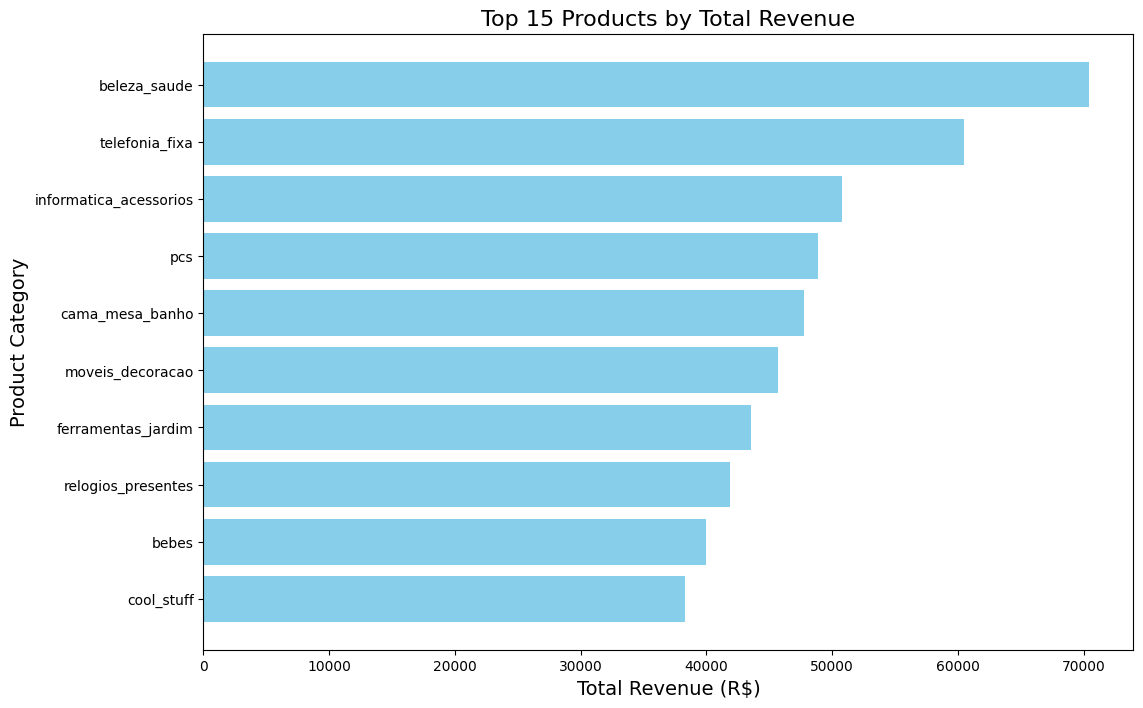

In [42]:
# Menggabungkan dataset products dengan dataset items
items_product = data['items'].merge(data['products'], on='product_id', how='inner')
# Menggabungkan dataset orders dengan dataset yang telah digabungkan sebelumnya (items_product)
orders_ip = data['orders'].merge(items_product, on='order_id', how='inner')

# Menghitung total penjualan dan probabilitas penjualan untuk setiap produk
product_revenue = orders_ip.groupby('product_id').agg({'order_item_id': 'sum', 'price': 'mean'})
product_revenue['total_revenue'] = product_revenue['order_item_id'] * product_revenue['price']
product_revenue['sell_probability'] = product_revenue['order_item_id'] / len(product_revenue)

# Mengurutkan produk berdasarkan total pendapatan
product_revenue = product_revenue.sort_values(by='total_revenue', ascending=False)

# Mengambil nama produk dari dataset products
product_names = data['products'][['product_id', 'product_category_name']].set_index('product_id')

# Menggabungkan nama produk dengan dataset product_revenue
product_revenue = product_revenue.join(product_names, how='left')

# Visualisasi 15 produk teratas berdasarkan total pendapatan
top_products = product_revenue.head(15)

plt.figure(figsize=(12, 8))
plt.barh(top_products['product_category_name'], top_products['total_revenue'], color='skyblue')
plt.xlabel('Total Revenue (R$)', fontsize=14)
plt.ylabel('Product Category', fontsize=14)
plt.title('Top 10 Products by Total Revenue', fontsize=16)
plt.gca().invert_yaxis()  # Membalikkan urutan kategori agar yang teratas berada di bagian atas
plt.show()


## Conclusion

- Barang yang banyak terjual adalah beleza_saude atau health_beauty
- Barang yang banyak mendatangkan keuntungan paling besar adalah barang dengan harga menengah yang memiliki banyak peminat